# ANALYSING CRIME DATA

I downloaded the crime data from https://data.police.uk/data/ which shows a collection of crime report for UK. I selected
City of London Police data as I am only interested in analysing crime in Westminster area. The data was stored as a 
CSV file format. I manually downloaded all files from 2010 to 2017, and read into a dataframe using Pandas module. The 
data was then analysed as on a map and as a bar chart.

# SECTION A

In [1]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import glob
import os
sns.set(style="whitegrid", color_codes=True)

source code credit :
    (https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)



In [2]:
#reading multiple crime data files 
path =r'/Users/jamessolomon/Desktop/DATA_SCIENCE/SEM2/PROJECT 16/Huddle-kingshackmarch2017/crime' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
crime_df  = pd.concat(df_from_each_file, ignore_index=True)

In [3]:
#checking the contents of the dataframe
crime_df.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2010-12,City of London Police,City of London Police,-0.112952,51.518267,On or near Southampton Buildings,E01000914,Camden 028B,Vehicle crime,NaN,NaN


In [4]:
#calculating number of records
len(crime_df)

44780

In [6]:
#removing text 
crime_df['Location']= crime_df['Location'].str.replace('On or near','')

In [7]:
#removing white space
crime_df['Location']= crime_df['Location'].str.strip()

In [8]:
#reading dataframe from another notebook
%store -r noise #read from NOISE notebook file
%store -r complete_wards #read from LICENCE notebook file

In [9]:
#comparing noise and crime dataframes to output same street found in Westminster
lst = []
for i in noise.Street:
    for j in crime_df.Location:
        if i==j:
            lst.append(i)

In [10]:
#printing dataframe where street in Noise data is same as Crime data
crime_df2 = crime_df[crime_df.Location.isin(lst)].reset_index(drop=True)

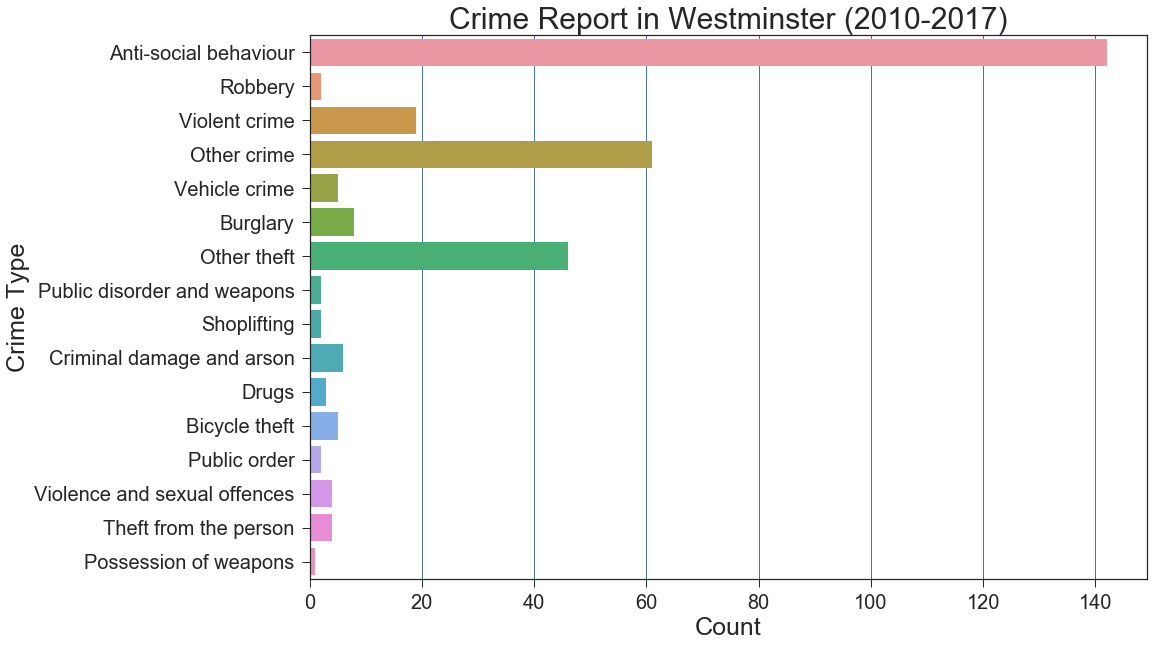

In [11]:
#plotting the number of complaints received for each day in the evening throughout the three year period
sns.set(font_scale=1.6)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig, ax = plt.subplots(figsize=(15,10))
ax.xaxis.grid(which='major',color='b') #showing vertical grid
sns.countplot(y='Crime type',data=crime_df2)
plt.title('Crime Report in Westminster (2010-2017)',fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.xlabel('Count', fontsize=25)
plt.ylabel('Crime Type',fontsize=25)
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/crime_bar.png',bbox_inches="tight")

# SECTION B

This seciton creates the overlay map using the geodataframe of the crime dataset. It uses the geometry column created 
to overlay the point on Westminster map.

In [12]:
#creating a copy of data
crm = crime_df.copy()

In [13]:
#removing na values in coordinates which throws Rtree error
crm=crm.dropna(subset=["Latitude", "Longitude"])

In [14]:
#creating geometry points of dataframe
crm['geometry'] = [Point(xy) for xy in zip(crm.Longitude, crm.Latitude)]

#creating a geodataframe and setting to the right coordinate reference system (crs)
crm_geo = gpd.GeoDataFrame(crm, crs={'init' :'epsg:4326'})

#setting both dataframes to same crs
crm_geo = crm_geo.to_crs(complete_wards.crs)

#creating a spatial join of shape file and geodataframe
crm_join = gpd.sjoin(crm_geo, complete_wards, how="inner", op='intersects')

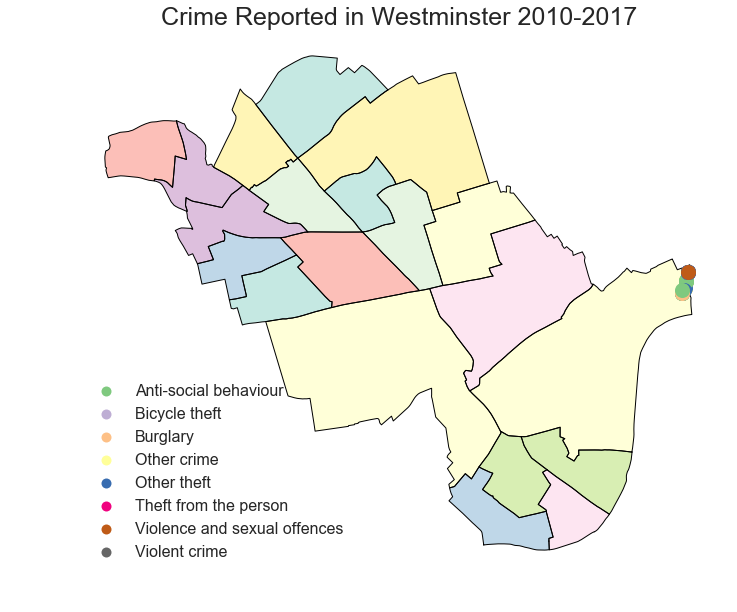

In [15]:
#plotting premises activity type in Westminster
base = complete_wards.plot(figsize=(15,10),cmap='Set3')
crm_join.plot(ax=base, marker='o', cmap='Accent', markersize=15, column='Crime type',legend=True,alpha=1)
plt.title('Crime Reported in Westminster 2010-2017',fontsize=25)
plt.axis('off')
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/crime_map.png',bbox_inches="tight")

In [16]:
#counting the total crime report per crime type
crime_df3 = pd.DataFrame(crime_df2.groupby('Crime type')['Crime type'].count())

In [17]:
#renaming column attribute
crime_df3 = crime_df3.rename(columns={'Crime type':'Total'})

In [18]:
#printing dataframe
crime_df3

,Total
Crime type,
Anti-social behaviour,142
Bicycle theft,5
Burglary,8
Criminal damage and arson,6
Drugs,3
Other crime,61
Other theft,46
Possession of weapons,1
Public disorder and weapons,2
